In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/cEOF_tropics_extratropics/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### AR time series

In [4]:
## Select MERRA2 or ERA5
reanalysis = 'era5'

if reanalysis == 'era5':
    start_date = '1979-01-01'
    end_date = '2018-12-31'
    filename = 'ar_catalog_ERAI_fraction_HASIAsubregions.nc'
## if MERRA2
else:
    start_date = '1980-01-01'
    end_date = '2017-12-31'
    filename = 'ar_catalog_fraction_HASIAsubregions.nc'
    
f1 = path_to_data + 'CH1_generated_data/' + filename
ds = xr.open_dataset(f1)
# Set dates
ds = ds.sel(time=slice(start_date, end_date))
## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()

,R01,R02,R03,ar,location
time,,,,,
1979-01-01,0.000000,0.0,0.0,0,NaN
1979-01-02,0.000000,0.0,0.0,0,NaN
1979-01-03,0.005102,0.0,0.0,0,NaN
1979-01-04,0.000000,0.0,0.0,0,NaN
1979-01-05,0.000000,0.0,0.0,0,NaN


### Import reanalysis

#### ERA5

In [5]:
## Set variable names (for saving data/figs)
var_names = 'IVT'
eofmode = 't' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance

# Select lat/lon grid
lonmin = 0
lonmax = 120
latmin = 0
latmax =  50

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat


### ERA5 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open IVT anomaly data
filepath_pattern = path_to_data + 'ERA5/ivt/daily/out.era5_hma_05dg_daily_ivt_*.nc'
f1 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(f1.nbytes / 1e9))

# Create new dataset to rename lat lon
ds = xr.Dataset({'ivte': (['time', 'lat', 'lon'], f1['p71.162'].values),
                  'ivtn': (['time', 'lat', 'lon'], f1['p72.162'].values)},
                  coords={'time': (['time'], f1.time.values),
                          'lat': (['lat'], f1.latitude.values),
                          'lon': (['lon'], f1.longitude.values)})

ds

ds size in GB 2.85



<xarray.Dataset>
Dimensions:  (lat: 101, lon: 241, time: 14610)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.0 118.5 119.0 119.5 120.0
Data variables:
    ivte     (time, lat, lon) float32 -1.949585 0.36058044 ... 336.15054
    ivtn     (time, lat, lon) float32 -42.10005 -40.867218 ... -32.044495

In [6]:
# Add AR time series to merra; set as coordinate variables
ds['ar'] = ('time', df.ar)
ds = ds.set_coords('ar')

ds['location'] = ('time', df.location)
ds = ds.set_coords('location')

# print dataset
print(ds)

<xarray.Dataset>
Dimensions:   (lat: 101, lon: 241, time: 14610)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01T09:00:00 ... 2018-12-31T09:00:00
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    location  (time) object nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    ivte      (time, lat, lon) float32 -1.949585 0.36058044 ... 336.15054
    ivtn      (time, lat, lon) float32 -42.10005 -40.867218 ... -32.044495


### Data Subset Selection

In [7]:
# Trim date range
if reanalysis == 'era5':
    start_date = '1979-12-01'
    end_date = '2018-02-28'
    ys = 1979
    ye = 2018
else:
    start_date = '1980-12-01'
    end_date = '2017-02-28'
    ys = 1980
    ye = 2017
    
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select DJF months
idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 2)
ds = ds.sel(time=idx)

# # Select AR days JUST IN R01
# idx = (ds.ar >= 1) & (ds.location == 'R01')
# Select AR days in all subregions
idx = (ds.ar >= 1)
ds_ar = ds.sel(time=idx)

# print results
print(ds_ar)

<xarray.Dataset>
Dimensions:   (lat: 101, lon: 241, time: 371)
Coordinates:
  * time      (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat       (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * lon       (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
    ar        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location  (time) object 'R03' 'R01' 'R01' 'R01' ... 'R03' 'R02' 'R01' 'R01'
Data variables:
    ivte      (time, lat, lon) float32 236.6193 241.0619 ... 110.214935
    ivtn      (time, lat, lon) float32 -19.468597 -21.229797 ... -43.313354


In [8]:
# Count number of independent AR events

years = np.arange(ys, ye) 
nyrs = len(years)
total_events = 0
for k in range(nyrs-1):    
    # Extract single DJF season
    date1 = "{}-12-01".format(years[k])
    date2 = "{}-02-28".format(years[k+1])
    x = ds.ar.sel(time=slice(date1,date2)).values
    # Count AR events in that season
    tags, tmp = persistence(x)
    # Add to running event count
    total_events += tmp

print("Number of independent AR events: ", total_events)

Number of independent AR events:  199


#### Import Eigenvectors

In [9]:
## import HMA loadings s-mode correlation matrix
filename = path_to_out + 'loadings_HUVQ500s0120-1565cor.txt'
col_names = ['PC1', 'PC2', 'PC3', 'PC4']
df1 = pd.read_csv(filename, header=None, names=col_names)
df1

,PC1,PC2,PC3,PC4
0,0.4215,-0.1220,-0.0485,0.2982
1,0.3541,0.1219,-0.1874,0.1632
2,0.1835,-0.1576,-0.1959,-0.2787
3,0.1438,-0.1372,-0.0780,-0.4490
4,0.0780,0.1775,0.1911,0.1135
...,...,...,...,...
366,-0.0331,-0.1313,0.0894,0.0299
367,0.0257,-0.2363,0.1994,0.0384
368,-0.4807,0.3162,0.3744,0.1905
369,-0.2080,0.0017,0.0348,-0.0076


In [10]:
evecs = df1.to_numpy()
evecs.shape

(371, 4)

### EOF represented as correlation

In [12]:
# put PCS into dataset object
npcs = 2
ds_pc = xr.Dataset({'pc': (['time', 'pcs'], evecs[:,0:npcs])},
                      coords={'time': (['time'], ds_ar.time.values),
                              'pcs': (['pcs'], np.arange(npcs))})

# select the pc to correlate
pc1 = ds_pc.pc.sel(pcs=0)
pc2 = ds_pc.pc.sel(pcs=1)
# calculate statistics between AR ds and PCs
cor1, pval1, tstat1 = correlation_pvalue(x=pc1, y=ds_ar, n=total_events)
cor2, pval2, tstat2 = correlation_pvalue(x=pc2, y=ds_ar, n=total_events)

# ## combine cor1 and cor2 into 1 ds object
ds_cor = xr.concat([cor1, cor2], dim='pcs')
ds_pval = xr.concat([pval1, pval2], dim='pcs')
ds_tstat = xr.concat([tstat1, tstat2], dim='pcs')

In [13]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 2

# Data for plotting extratropics
lons = ds_ar.lon.data
lats = ds_ar.lat.data

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


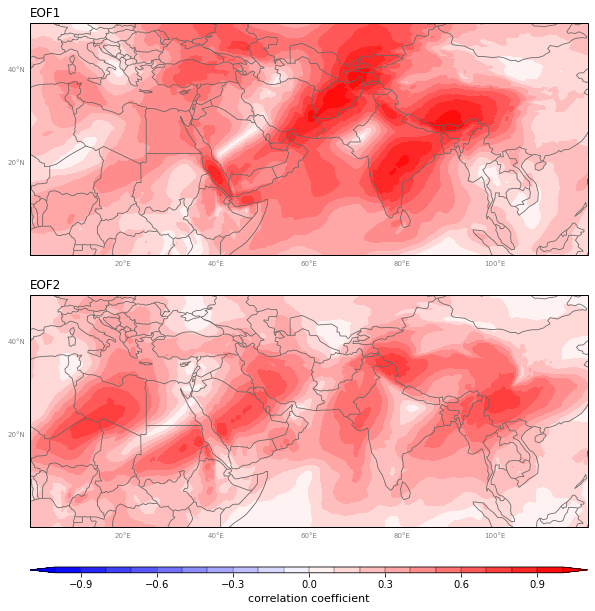

In [16]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'cors_ivt'+ fname_id + '.png'
nrows = 2
ncols = 1
# sns.set_style('ticks')
eof_label = ['EOF1', 'EOF2', 'EOF3', 'EOF4']
# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='2.5%',
                label_mode='')

#newcmap = cmocean.tools.crop_by_percent(cmo.matter, 15, which='max', N=None)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
#     ax = draw_basemap(ax, extent=None, xticks=dx, yticks=dy)
    
    # Add contour fill plot for IVT
    udat = ds_cor.ivte.sel(pcs=k)
    vdat = ds_cor.ivtn.sel(pcs=k)
    data = np.sqrt(udat**2 + vdat**2)
    clevs = np.arange(-1,1.1,0.1)
    cf = ax.contourf(lons, lats, data, transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
#     # add vectors for extratropics
#     ax.quiver(lons, lats, udat[k,:,:], vdat[k,:,:], transform=datacrs,
#               color='black', pivot='middle', regrid_shape=30)

    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
#     ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('correlation coefficient', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()